In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom #pip install pydicom
import cv2 #pip install opencv-python
import tensorflow as tf
import shutil

In [21]:
pydicom.__version__
tf.__version__# 要用2.0以上的版本

'2.15.0'

# 数据预处理

## 数据读取

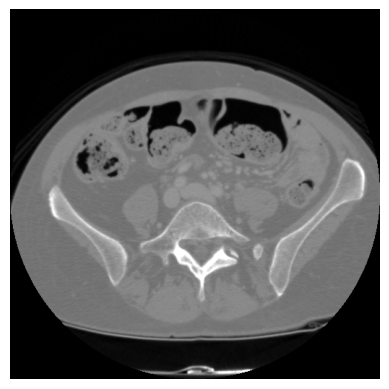

In [22]:
data_path = r'D:\deepL\winter\3Dircadb1\3Dircadb1.1\PATIENT_DICOM'
#读取单张图片
img = pydicom.dcmread(os.path.join(data_path,'image_0'))
plt.imshow(img.pixel_array,cmap='gray')#灰度图
plt.axis('off')#去掉坐标轴
plt.show()

In [23]:
#批量数据读取
image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
os.listdir(data_path)#默认按照字符排序，顺序乱掉了
#重新排序,避免CT图乱序
image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取像素值
image_array = np.array([i.pixel_array for i in image_slices])

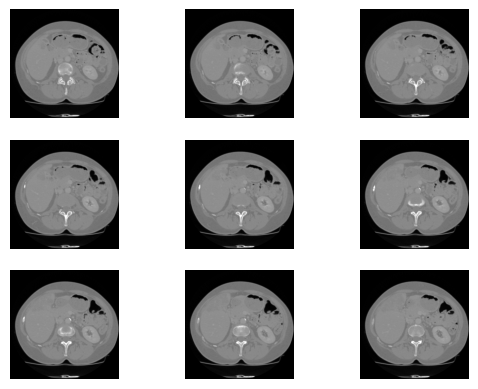

In [24]:
#可视化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(image_array[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## CT图增强-windowing

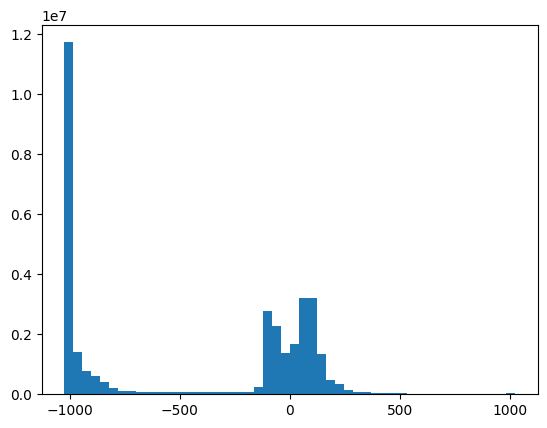

In [25]:
plt.hist(image_array.reshape(-1,),bins=50)
plt.show()

In [26]:
#给定windowing自定义函数
def windowing(img, window_width, window_center):
    #img： 需要增强的图片
    #window_width:窗宽
    #window_center:中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8') #把数据整理成标准图像格式

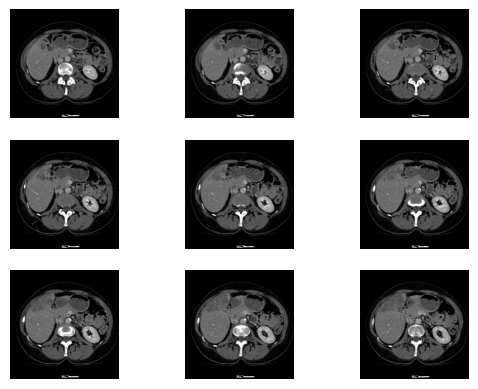

In [27]:
img_ct = windowing(image_array,500,150)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

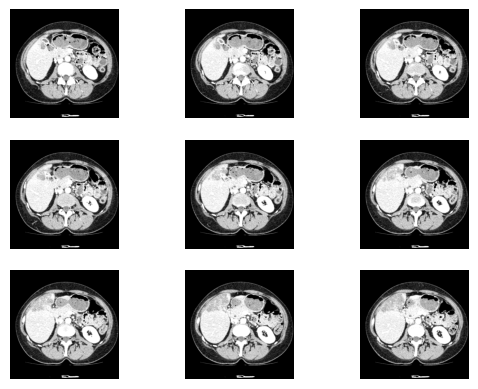

In [28]:
img_ct = windowing(image_array,250,0)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 直方图均衡化

In [29]:
# img_ct.shape
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
# clahe.apply(img_ct[0])#一次只能处理一张图片
#自定义批量均衡化函数
def clahe_equalized(imgs):
    #输入imgs的形状必须是3维的 （129,512,512）
    assert(len(imgs.shape ) == 3)
    #定义均衡化函数
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
    #新数组用来存放均衡化后的数据
    img_res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        img_res[i,:,:] = clahe.apply(np.array(imgs[i,:,:],dtype=np.uint8))
    return img_res/255.0

In [30]:
img_clahe = clahe_equalized(img_ct)

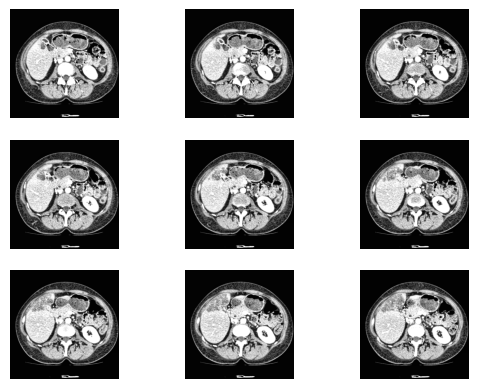

In [31]:
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_clahe[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 提取肿瘤部位的CT图和掩模图


In [32]:
#只用一个肿瘤示范
data_path_mask = r'D:\deepL\winter\3Dircadb1\3Dircadb1.1\MASKS_DICOM\livertumor01'
#批量数据读取
tumor_slices = [pydicom.dcmread(os.path.join(data_path_mask,file_name)) for file_name in os.listdir(data_path)]
#重新排序,避免CT图乱序
tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取像素值
tumor_array = np.array([i.pixel_array for i in tumor_slices])

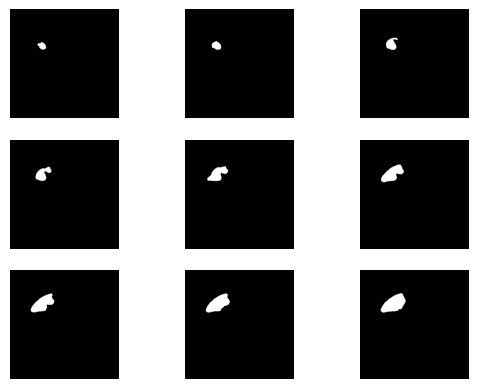

In [33]:
#可视化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(tumor_array[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

In [34]:
#没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
#提取掩模图的肿瘤部分
img_tumor = tumor_array[index]
#对增强后的CT图提取肿瘤部分
img_patient = img_clahe[index]

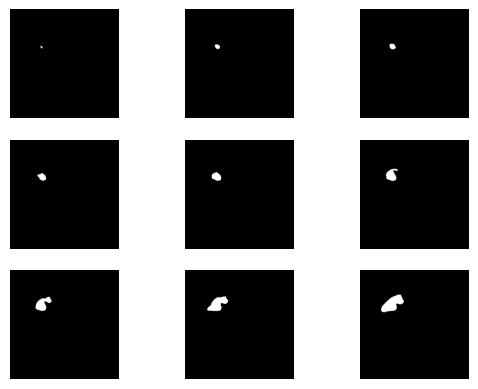

In [35]:
#可视化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_tumor[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

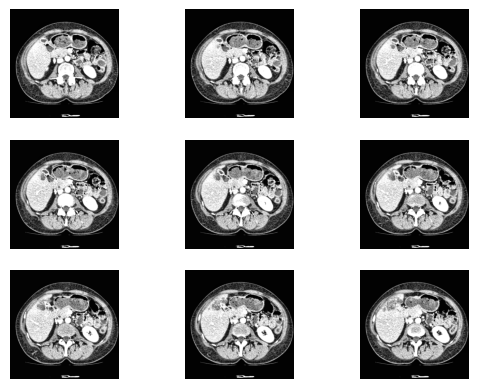

In [36]:
#可视化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_patient[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 保存肿瘤数据

In [37]:
#设置保存文件的路径
patient_save_path = r'E:/肝脏/06.数据/tmp/patient'
tumor_save_path = r'E:/肝脏/06.数据/tmp/tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断文件夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空文件夹用来存放数据

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'E:/'

In [ ]:
# #保留一个肿瘤的数据
# for i in range(len(img_patient)):
#     plt.imsave(os.path.join(patient_save_path,f'{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
#     plt.imsave(os.path.join(tumor_save_path,f'{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图

In [ ]:
#保存所有的肿瘤数据
livertumor_path = r'E:\肝脏\06.数据\data\3Dircadb1\3Dircadb1.1\MASKS_DICOM'
#肿瘤路径
tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
tumor_paths.sort()
#提取所有肿瘤数据
j = 0
for tumor_path in tumor_paths:
    print('正在处理第%d个肿瘤'%j)
    #批量数据读取
    tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
    #重新排序,避免CT图乱序
    tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取像素值
    tumor_array = np.array([i.pixel_array for i in tumor_slices])
    #没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
    index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
    #提取掩模图的肿瘤部分
    img_tumor = tumor_array[index]
    #对增强后的CT图提取肿瘤部分
    img_patient = img_clahe[index]
    #保存数据
    for i in range(len(img_patient)):
        plt.imsave(os.path.join(patient_save_path,f'{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
        plt.imsave(os.path.join(tumor_save_path,f'{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
    j += 1

## 对所有病人数据做处理

In [ ]:
#设置保存文件的路径
patient_save_path = r'E:/肝脏/06.数据/tmp/patient'
tumor_save_path = r'E:/肝脏/06.数据/tmp/tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断文件夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空文件夹用来存放数据

In [ ]:
for num in range(1,21):
    print('正在处理第%d位病人的数据'%num)
    #======CT图处理===================
    #读取CT图数据
    data_path = fr'E:\肝脏\06.数据\data\3Dircadb1\3Dircadb1.{num}\PATIENT_DICOM'
    #批量数据读取
    image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
    os.listdir(data_path)#默认按照字符排序，顺序乱掉了
    #重新排序,避免CT图乱序
    image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取像素值
    image_array = np.array([i.pixel_array for i in image_slices])
    #CT图增强-windowing
    img_ct = windowing(image_array,250,0)
    #直方图均衡化
    img_clahe = clahe_equalized(img_ct)
    #=======掩模图处理==================================
    #保存所有的肿瘤数据
    livertumor_path = fr'E:\肝脏\06.数据\data\3Dircadb1\3Dircadb1.{num}\MASKS_DICOM'
    #肿瘤路径
    tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
    tumor_paths.sort()
    #提取所有肿瘤数据
    j = 0
    for tumor_path in tumor_paths:
        print('正在处理第%d个肿瘤'%j)
        #批量数据读取
        tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
        #重新排序,避免CT图乱序
        tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
        #提取像素值
        tumor_array = np.array([i.pixel_array for i in tumor_slices])
        #没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
        index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
        #提取掩模图的肿瘤部分
        img_tumor = tumor_array[index]
        #对增强后的CT图提取肿瘤部分
        img_patient = img_clahe[index]
        #保存数据
        for i in range(len(img_patient)):
            plt.imsave(os.path.join(patient_save_path,f'{num}_{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
            plt.imsave(os.path.join(tumor_save_path,f'{num}_{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
        j += 1

# 图像数据增强

In [ ]:
import os
import shutil
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import  backend as K
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 定义图片生成器

In [ ]:
generator_args = dict(
    rotation_range = 0.1,#旋转角度
    width_shift_range = 0.05,#水平移动
    height_shift_range = 0.05,#垂直移动
    shear_range = 0.05,#剪切
    zoom_range = 0.05,#缩放
    horizontal_flip = False,#水平翻转
    vertical_flip = False,#垂直翻转
)
ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器

## 图像增强实现

In [ ]:
#保存图形增强后数据的路径
save_datagen_path = r'E:\肝脏\06.数据\tmp2'
if os.path.exists(save_datagen_path):
    shutil.rmtree(save_datagen_path)
os.makedirs(save_datagen_path)

In [ ]:
#目标路径--ct的增强
generator_path = r'E:\肝脏\06.数据\tmp'
ct_generator = ct_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['patient'],#处理的文件夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    save_to_dir = save_datagen_path,#保存
    save_prefix = 'ct_' ,#增强后图片的前缀
    seed = 123,
)
mask_generator = mask_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['tumor'],#处理的文件夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    save_to_dir = save_datagen_path,#保存
    save_prefix = 'mask_' ,#增强后图片的前缀
    seed = 123,
)
train_generator = zip(ct_generator,mask_generator)#成组处理

Found 643 images belonging to 1 classes.
Found 643 images belonging to 1 classes.


C:\Users\45543\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(512, 512) (2, 512, 512, 1)


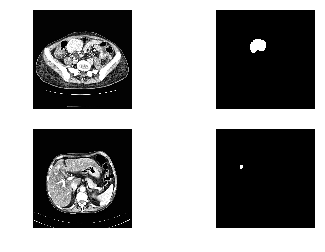

In [ ]:
#可视化
for ct,mask in train_generator:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()

## 图像归一化

In [ ]:
def adjust_data(ct,mask):
    #ct： CT图
    #mask：掩模图
    ct = ct/255.0
    mask = mask/255.0
    mask[mask>0.5] = 1#对掩模图做灰度处理
    mask[mask<=0.5] = 0
    return ct,mask

## 整合图像增强的步骤

In [ ]:
#自定义图像增强函数
def train_generator():
    #======1、定义图像生成器============================
    generator_args = dict(
        rotation_range = 0.1,#旋转角度
        width_shift_range = 0.05,#水平移动
        height_shift_range = 0.05,#垂直移动
        shear_range = 0.05,#剪切
        zoom_range = 0.05,#缩放
        horizontal_flip = False,#水平翻转
        vertical_flip = False,#垂直翻转
    )
    #=====2、分别对CT图和掩模图做图像增强===================================
    ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
    mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器
    
    #====3、实现图像增强=====================================================
    generator_path = r'E:\肝脏\06.数据\tmp'
    ct_generator = ct_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['patient'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'ct_' ,#增强后图片的前缀
        seed = 123,
    )
    mask_generator = mask_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['tumor'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'mask_' ,#增强后图片的前缀
        seed = 123,
    )
    train_generator = zip(ct_generator,mask_generator)#成组处理
    #============4、增强后的图片做归一化处理==========================
    for (ct,mask) in train_generator:
        yield adjust_data(ct,mask)

Found 643 images belonging to 1 classes.
Found 643 images belonging to 1 classes.
(512, 512) (2, 512, 512, 1)


C:\Users\45543\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


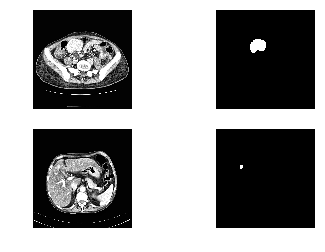

In [ ]:
gene = train_generator() #模型的输入和输出，可以直接放在模型的训练里面
#可视化
for ct,mask in gene:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()

# 构建模型

## 搭建模型

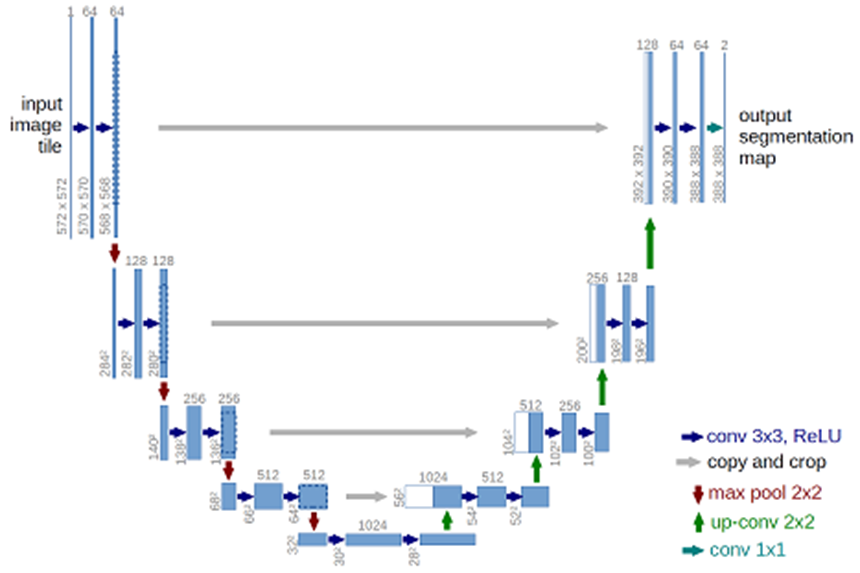

In [ ]:
# from tensorflow.keras import  backend as K
# from tensorflow.keras.layers import  *
K.clear_session()

def u_net(input_size=(512,512,1),path = model_path):
    inputs = Input(input_size)
    conv1 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    conv4 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv3)
    pool2 = MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    conv6 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv5)
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    
    conv7 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    conv8 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv7)
    pool4 = MaxPool2D(pool_size=(2,2))(conv8)
    
    conv9 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    conv10 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv9)
    up1 = UpSampling2D((2,2))(conv10)#反卷积
    
    conv11 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up1,conv8],axis=3))#开始右半部分
    conv12 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv11)
    up2 = UpSampling2D((2,2))(conv12)#反卷积
    
    conv13 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up2,conv6],axis=3))
    conv14 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv13)
    up3 = UpSampling2D((2,2))(conv14)#反卷积
    
    conv15 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up3,conv4],axis=3))
    conv16 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv15)
    up4 = UpSampling2D((2,2))(conv16)#反卷积
    
    conv17 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up4,conv2],axis=3))
    conv18 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv17)
    out = Conv2D(1,1,activation='sigmoid')(conv18)
    
    model = tf.keras.Model(inputs = inputs,outputs = out)#构建模型
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])#模型编译
    #model.summary()
    return model

In [ ]:
model = u_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 模型训练

In [ ]:
model_path = r'E:\肝脏\06.数据\tmp\model.h5'
model_ckpt = ModelCheckpoint(model_path,save_best_only=False,verbose=1)
class ShowMask(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        print()
        for ct, mask in gene:
            plt.subplot(1, 3, 1)
            plt.imshow(ct[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0], cmap='gray')
            plt.axis('off')  
            plt.subplot(1, 3, 3)
            plt.imshow(model.predict(ct[0].reshape(1, 512, 512, 1))[0], cmap='gray')
            plt.axis('off')  
            plt.show()
            break

model.fit(gene,steps_per_epoch=4,epochs=2,callbacks=[model_ckpt,ShowMask()])

C:\Users\45543\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2


## 模型预测

In [ ]:
patient_id = '1_58_10'
# 1.1读取病人的CT图（tmp文件夹，已经做了windowing、直方图均衡化）
patient_ct = cv2.imread(f'./tmp/patient/{patient_id}.jpg')
# 1.2读取病人掩膜图
patient_mask = cv2.imread(f'./tmp/tumor/{patient_id}.jpg', cv2.IMREAD_GRAYSCALE)


# 2.1模型加载（已经训练好的模型）
model_test = tf.keras.models.load_model('./u_net-512-512-1-liver_tumor5.h5')
# 2.2 模型输入的处理
# 2.2.1 灰度处理
ct_gray = cv2.cvtColor(patient_ct, cv2.COLOR_BGR2GRAY)
# 2.2.2 数据形状（batch_size, img_height, img_height, img_channel_size）
ct_gray = ct_gray.reshape((1, 512, 512, 1))
# 2.2.3 归一化
ct_gray = ct_gray/ 255.
# 2.3 模型预测
pred_mask = model_test.predict(ct_gray)[0]

# 3结果展示
_, patient_mask = cv2.threshold(patient_mask, 127, 255, 0)
# 3.1轮廓线提取
contours, _ = cv2.findContours(patient_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 3.2在CT图上绘制轮廓线
overlap_img = cv2.drawContours(patient_ct.copy(), contours, -1, (0, 255, 0), 2)
# 3.3 展示
cv2.imshow('real', overlap_img)
cv2.waitKey(0)


# 3结果展示
_, bi_mask = cv2.threshold((pred_mask*255).astype('uint8'), 127, 255, 0)
# 3.1轮廓线提取
contours, _ = cv2.findContours(bi_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 3.2在CT图上绘制轮廓线
overlap_img2 = cv2.drawContours(patient_ct.copy(), contours, -1, (255, 0, 0), 2)
# 3.3 展示
cv2.imshow('predict', overlap_img2)
cv2.waitKey(0)